# Flax-pilot Trainer with pre-trained models


**Use TensorFlow-cpu instead of TensorFlow to avoid any issues between TensorFlow & Jax.**

In [5]:
!pip install -q tensorflow-cpu

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.
tensorflow 2.15.0 requires ml-dtypes~=0.2.0, but you have ml-dtypes 0.3.2 which is incompatible.
tensorflow 2.15.0 requires tensorboard<2.16,>=2.15, but you have tensorboard 2.16.2 which is incompatible.


In [6]:
!pip install -q mergedeep

In [7]:
import jax
import optax
import functools
import tensorflow as tf
import flax.linen as nn
import jax.numpy as jnp
import jax.random as jr
from mergedeep import merge as dmerge

In [8]:
import jax, flax, orbax.checkpoint
jax.__version__, flax.__version__, orbax.checkpoint.__version__

('0.4.26', '0.8.4', '0.5.15')

In [9]:
import os
os.listdir("/kaggle/input/fpilot")

['trackers', 'checkpoints', 'opt_utils', 'training']

In [10]:
import glob, sys
sys.path.append("/kaggle/input")

**Refer to `vae-using-pre-trained` b4 using this notebook for better clarity**

In [11]:
class BackBone(nn.Module):
    @nn.compact
    def __call__(self, x, deterministic):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        return x

### Fine-tuning

**Lets use the backbone params for other tasks. In this example lets use the trained backbone for Encoder part of VAE-GAN-CFG**


**Extract the params of backbone**

In [51]:
temp_ckpt = orbax.checkpoint.PyTreeCheckpointer()
classifier_state = temp_ckpt.restore("/kaggle/working/pre-trained-models/manual_mnist_save2/2340/default")
base_params = classifier_state['params']['params']['base']

/opt/conda/lib/python3.10/site-packages/orbax/checkpoint/type_handlers.py:1401: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


**VAE-GAN-CFG Model**

**Lets use the backbone in the encoder.**

In [38]:
class Encoder(nn.Module):
    base: nn.Module = BackBone()
    
    def setup(self,):
        self.ff = nn.Sequential([
            nn.Dense(16),
            nn.relu,
            nn.Dense(4)
        ])
    
        
    def __call__(self, x, deterministic):
        x = self.base(x, deterministic)
        x = x.reshape(x.shape[0], -1)
        x = self.ff(x)
        mean, logvar = jnp.split(x, 2, -1)
        return mean, logvar
    
    
class Decoder(nn.Module):
    def setup(self,):
        self.cls_embedding = nn.Embed(10, 128)
    
    @nn.compact
    def __call__(self, z, c, deterministic):
        y = nn.relu(nn.Dense(49*128)(z))
        c = self.cls_embedding(c.astype(jnp.int32))
        
        y = y.reshape(y.shape[0], 7, 7, 128)
        y += c[:, None, None, :]
        y = nn.GroupNorm()(y)
        
        y = nn.gelu(nn.ConvTranspose(features=128, kernel_size=(3, 3), strides=2, padding='SAME')(y))
        y += c[: ,None, None, :]
        y = nn.GroupNorm()(y)
        
        y = nn.gelu(nn.ConvTranspose(features=64, kernel_size=(3, 3), strides=2, padding='SAME')(y))
        y += (nn.Dropout(0.3, deterministic=deterministic)(nn.Dense(64)(c))[:, None, None, :])
        y = nn.GroupNorm()(y)
        
        y = nn.ConvTranspose(features=1, kernel_size=(3, 3), padding='SAME')(y)
        y = nn.sigmoid(y)
        return y
    
        
class VAE(nn.Module):
    encoder: nn.Module = Encoder()
    decoder: nn.Module = Decoder()
    
    # Must have 'deterministic param'.
    @nn.compact
    def __call__(self, x, c, deterministic):
        mean, logvar = self.encode(x, deterministic)
        z = self.reparam_trick(mean, logvar)
        y = self.decode(z, c, deterministic)
        return (mean, logvar), y
        
    def encode(self, x, deterministic):
        return self.encoder(x, deterministic)
    
    def decode(self, x, c, deterministic):
        return self.decoder(x, c, deterministic)
    
    def reparam_trick(self, mean, logvar):
        e = jr.normal(self.make_rng('normal'), mean.shape)
        return mean + jnp.exp(0.5*logvar)*e
    

class Discriminator(nn.Module):
    @nn.compact
    def __call__(self, x, deterministic):
        x = nn.Conv(features=64, kernel_size=(5, 5), strides=(2, 2), padding='SAME')(x)
        x = nn.leaky_relu(x)
        x = nn.Dropout(0.3, deterministic=deterministic)(x)
        
        x = nn.Conv(features=128, kernel_size=(5, 5), strides=(2, 2), padding='SAME')(x)
        x = nn.leaky_relu(x)
        x = nn.Dropout(0.3, deterministic=deterministic)(x)
        
        x = x.reshape((x.shape[0], -1)) 
        x = nn.Dense(features=16)(x)
        return x

**Encapsulated Model**

In [39]:
class GAN(nn.Module):
    def setup(self,):
        self.discriminator = Discriminator()
        self.generator = VAE()
    
    @nn.compact
    def __call__(self, x, c, deterministic):
        (mean, logvar), y = self.generator_call(x, c, deterministic)
        dtrue = self.disc(x, deterministic)
        dfake = self.disc(y, deterministic)
        return y, mean, logvar, dtrue, dfake
    
    def generator_call(self, x, c, deterministic):
        return self.generator(x, c, deterministic)
    
    def decode(self, x, c, deterministic):
        return self.generator.decode(x, c, deterministic)
    
    def disc(self, x, deterministic):
        return self.discriminator(x, deterministic)

**Data loading**

In [40]:
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.mnist.load_data()

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(256).batch(128, True)

def func(x, c):
    return x[:, :, :, None]/255, c
    
train_ds = train_ds.map(func, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(2, True)
train_ds = train_ds.repeat().as_numpy_iterator()

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.shuffle(256).batch(128, True)
val_ds = val_ds.map(func, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(2, True)
val_ds = val_ds.repeat().as_numpy_iterator()

train_ds, val_ds

(NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x7a9980605e10>),
 NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x7a9980738ee0>))

**Loss function**

In [80]:
disc_start = 2000
disc_weight = 0.7
disc_factor_4_gen=0.3


def loss_fn(params, apply, sample, deterministic, global_key, step, obj):
    x, c = sample
    y, mean, logvar, dt, df = apply(params, x, c, deterministic=deterministic, rngs={'dropout': global_key, 'normal': global_key})

    if obj=='generator':
        recons_loss = -(x*jnp.log(y+0.00001) + (1-x)*jnp.log((1-y)+0.00001)).sum(axis=(1, 2)).mean()
        kl_loss = (-0.5 * (1 + logvar - jnp.square(mean) - jnp.exp(logvar))).sum(axis=(1, )).mean()
        gen_df_loss = -df.mean()
        loss = recons_loss + (kl_loss) + (gen_df_loss*disc_factor_4_gen)
        gen_loss = loss  
        
        return gen_loss, {
            'lt': {'recons_loss': recons_loss, 'kl_loss': kl_loss, 'gen_loss': gen_df_loss}, 
            'mt': dict()
        }

    if obj=='discriminator':
        disc_dt_loss = nn.relu(1.0 - dt).mean()
        disc_df_loss = nn.relu(1.0 + df).mean()
        disc_loss = 0.5* (disc_dt_loss + disc_df_loss)
        
        # Dynamic weighing
        weight = (step >= disc_start)*disc_weight
        disc_loss = disc_loss*weight
        
        return  disc_loss, {
            'lt': {'dict_true_op': dt.mean(), 'dict_fake_op': df.mean()}, 
            'mt': dict()
        }

**Trackers**

In [42]:
import fpilot.trackers.basic_trackers as tr

trackers = {
        'lt': {'recons_loss': tr.Mean(), 'kl_loss': tr.Mean(), 'gen_loss': tr.Mean(), 'dict_true_op': tr.Mean(), 'dict_fake_op': tr.Mean()},
        'mt':{}
}

**Create optimizer mask**

 - True: Apply Gradients
 - False: Dont Apply Gradients

In [92]:
mask = {
    'params': # first key `params` is default for any mask. 
        {'generator':
            {
                'encoder': {
                    'base': False,
                    'ff': True
                },
                'decoder': True
            },
         'discriminator': True
        }
}

**Initiate trainer**

In [93]:
from fpilot.training.trainer import Trainer

trainer = Trainer(GAN(), {'x': (1, 28, 28, 1), 'c': (1, )}, {'discriminator': optax.adam(4e-5), 'generator': optax.adam(4e-5)}, loss_fn, trackers, mask)

**Set the params of Backbone to its pre-trained weights**<br>
Check the docstring of the function for explaination

In [95]:
replacement_path = [
    ['params', 'generator', 'encoder', 'base']
]
replacement_params = [
    base_params
]
trainer.transfer_params(replacement_path, replacement_params)

**Train the VAE**

In [96]:
trainer.train(100, train_ds, val_ds, 60000//256, 10000//256, '/kaggle/working/gans-pretrained/gansprt3', 3)

Epoch 1: 100%|██████████| 234/234 [00:15<00:00, 14.70it/s]


Train:  dict_fake_op: 0.01878448, dict_true_op: 0.017963294, gen_loss: -0.01878448, kl_loss: 2.1625159, recons_loss: 306.6493, time: 15.919187307357788
Val:  dict_fake_op: 0.026127433, dict_true_op: 0.023588521, gen_loss: -0.026127433, kl_loss: 3.3908205, recons_loss: 201.51215, time: 2.9637036323547363
State saved..


Epoch 2: 100%|██████████| 234/234 [00:07<00:00, 30.14it/s]


Train:  dict_fake_op: 0.020877695, dict_true_op: 0.018193012, gen_loss: -0.020877695, kl_loss: 3.588245, recons_loss: 193.13748, time: 7.76607871055603
Val:  dict_fake_op: 0.02646186, dict_true_op: 0.02358024, gen_loss: -0.02646186, kl_loss: 3.629521, recons_loss: 184.23529, time: 0.4437093734741211
State saved..


Epoch 3: 100%|██████████| 234/234 [00:07<00:00, 29.77it/s]


Train:  dict_fake_op: 0.02017135, dict_true_op: 0.01797095, gen_loss: -0.02017135, kl_loss: 3.4962015, recons_loss: 181.3917, time: 7.864343643188477
Val:  dict_fake_op: 0.025759023, dict_true_op: 0.023579862, gen_loss: -0.025759023, kl_loss: 3.4830382, recons_loss: 174.15738, time: 0.4481532573699951
State saved..


Epoch 4: 100%|██████████| 234/234 [00:07<00:00, 29.86it/s]


Train:  dict_fake_op: 0.019932687, dict_true_op: 0.017941475, gen_loss: -0.019932687, kl_loss: 3.6364534, recons_loss: 171.86388, time: 7.84030818939209
Val:  dict_fake_op: 0.0250519, dict_true_op: 0.023578718, gen_loss: -0.0250519, kl_loss: 3.9297194, recons_loss: 165.24457, time: 0.43929290771484375
State saved..


Epoch 5: 100%|██████████| 234/234 [00:07<00:00, 30.16it/s]


Train:  dict_fake_op: 0.0197272, dict_true_op: 0.01796877, gen_loss: -0.0197272, kl_loss: 4.192278, recons_loss: 163.99182, time: 7.762681245803833
Val:  dict_fake_op: 0.024619691, dict_true_op: 0.023567561, gen_loss: -0.024619691, kl_loss: 4.4851427, recons_loss: 158.44058, time: 0.434816837310791
State saved..


Epoch 6: 100%|██████████| 234/234 [00:07<00:00, 30.37it/s]


Train:  dict_fake_op: 0.019238615, dict_true_op: 0.017903887, gen_loss: -0.019238615, kl_loss: 4.6790514, recons_loss: 157.74295, time: 7.707836866378784
Val:  dict_fake_op: 0.024686413, dict_true_op: 0.023574514, gen_loss: -0.024686413, kl_loss: 4.9072866, recons_loss: 153.06866, time: 0.43648219108581543
State saved..


Epoch 7: 100%|██████████| 234/234 [00:07<00:00, 30.57it/s]


Train:  dict_fake_op: 0.01950698, dict_true_op: 0.017909424, gen_loss: -0.01950698, kl_loss: 5.044505, recons_loss: 153.0682, time: 7.65777063369751
Val:  dict_fake_op: 0.024551785, dict_true_op: 0.023587145, gen_loss: -0.024551785, kl_loss: 5.2050686, recons_loss: 149.3614, time: 0.433657169342041
State saved..


Epoch 8: 100%|██████████| 234/234 [00:07<00:00, 30.64it/s]


Train:  dict_fake_op: 0.019467097, dict_true_op: 0.01808539, gen_loss: -0.019467097, kl_loss: 5.2872734, recons_loss: 149.77826, time: 7.640480041503906
Val:  dict_fake_op: 0.02427651, dict_true_op: 0.023590574, gen_loss: -0.02427651, kl_loss: 5.4085217, recons_loss: 146.63794, time: 0.4351072311401367
State saved..


Epoch 9: 100%|██████████| 234/234 [00:07<00:00, 30.37it/s]


Train:  dict_fake_op: -0.4247622, dict_true_op: 0.94209087, gen_loss: 0.4247622, kl_loss: 5.4434695, recons_loss: 147.3199, time: 7.707231521606445
Val:  dict_fake_op: -2.105507, dict_true_op: 3.4089355, gen_loss: 2.105507, kl_loss: 5.5362153, recons_loss: 144.83118, time: 0.4385089874267578
State saved..


Epoch 10: 100%|██████████| 234/234 [00:07<00:00, 30.20it/s]


Train:  dict_fake_op: -1.9996705, dict_true_op: 4.5720387, gen_loss: 1.9996705, kl_loss: 5.5495806, recons_loss: 145.48093, time: 7.751805782318115
Val:  dict_fake_op: -2.780497, dict_true_op: 5.085278, gen_loss: 2.780497, kl_loss: 5.634285, recons_loss: 143.26625, time: 0.4368000030517578
State saved..


Epoch 11: 100%|██████████| 234/234 [00:07<00:00, 30.14it/s]


Train:  dict_fake_op: -2.252133, dict_true_op: 5.927864, gen_loss: 2.252133, kl_loss: 5.637058, recons_loss: 143.93942, time: 7.766874551773071
Val:  dict_fake_op: -2.9699762, dict_true_op: 6.0157585, gen_loss: 2.9699762, kl_loss: 5.702502, recons_loss: 141.97394, time: 0.440732479095459
State saved..


Epoch 12: 100%|██████████| 234/234 [00:07<00:00, 30.10it/s]


Train:  dict_fake_op: -2.39109, dict_true_op: 6.64991, gen_loss: 2.39109, kl_loss: 5.700075, recons_loss: 142.67249, time: 7.776487827301025
Val:  dict_fake_op: -3.1167479, dict_true_op: 6.53292, gen_loss: 3.1167479, kl_loss: 5.758829, recons_loss: 140.76367, time: 0.4372286796569824
State saved..


Epoch 13: 100%|██████████| 234/234 [00:07<00:00, 30.12it/s]


Train:  dict_fake_op: -2.5071392, dict_true_op: 7.1023707, gen_loss: 2.5071392, kl_loss: 5.75284, recons_loss: 141.58786, time: 7.771389007568359
Val:  dict_fake_op: -3.2343998, dict_true_op: 6.88645, gen_loss: 3.2343998, kl_loss: 5.809284, recons_loss: 139.93106, time: 0.4414658546447754
State saved..


Epoch 14: 100%|██████████| 234/234 [00:07<00:00, 30.17it/s]


Train:  dict_fake_op: -2.622293, dict_true_op: 7.4161468, gen_loss: 2.622293, kl_loss: 5.7905273, recons_loss: 140.59238, time: 7.759625434875488
Val:  dict_fake_op: -3.3400016, dict_true_op: 7.1781445, gen_loss: 3.3400016, kl_loss: 5.8454256, recons_loss: 139.0086, time: 0.43958401679992676
State saved..


Epoch 15: 100%|██████████| 234/234 [00:07<00:00, 30.25it/s]


Train:  dict_fake_op: -2.7059283, dict_true_op: 7.686283, gen_loss: 2.7059283, kl_loss: 5.8273125, recons_loss: 139.76367, time: 7.737538814544678
Val:  dict_fake_op: -3.4989386, dict_true_op: 7.287861, gen_loss: 3.4989386, kl_loss: 5.880183, recons_loss: 138.36113, time: 0.4396398067474365
State saved..


Epoch 16: 100%|██████████| 234/234 [00:07<00:00, 30.29it/s]


Train:  dict_fake_op: -2.8115625, dict_true_op: 7.8730693, gen_loss: 2.8115625, kl_loss: 5.856602, recons_loss: 138.99142, time: 7.728065252304077
Val:  dict_fake_op: -3.5725932, dict_true_op: 7.5393457, gen_loss: 3.5725932, kl_loss: 5.910737, recons_loss: 137.79993, time: 0.4362168312072754
State saved..


Epoch 17: 100%|██████████| 234/234 [00:07<00:00, 30.31it/s]


Train:  dict_fake_op: -2.911025, dict_true_op: 8.069626, gen_loss: 2.911025, kl_loss: 5.8793097, recons_loss: 138.31688, time: 7.7244110107421875
Val:  dict_fake_op: -3.6707044, dict_true_op: 7.679619, gen_loss: 3.6707044, kl_loss: 5.928296, recons_loss: 137.22998, time: 0.43796372413635254
State saved..


Epoch 18: 100%|██████████| 234/234 [00:07<00:00, 30.35it/s]


Train:  dict_fake_op: -3.0042315, dict_true_op: 8.238804, gen_loss: 3.0042315, kl_loss: 5.8975134, recons_loss: 137.76593, time: 7.713231563568115
Val:  dict_fake_op: -3.7644587, dict_true_op: 7.872077, gen_loss: 3.7644587, kl_loss: 5.9432573, recons_loss: 136.68509, time: 0.4387221336364746
State saved..


Epoch 19: 100%|██████████| 234/234 [00:07<00:00, 30.33it/s]


Train:  dict_fake_op: -3.0918837, dict_true_op: 8.39984, gen_loss: 3.0918837, kl_loss: 5.9145536, recons_loss: 137.18832, time: 7.717461824417114
Val:  dict_fake_op: -3.9334002, dict_true_op: 7.93727, gen_loss: 3.9334002, kl_loss: 5.959214, recons_loss: 136.16586, time: 0.4405550956726074
State saved..


Epoch 20: 100%|██████████| 234/234 [00:07<00:00, 30.26it/s]


Train:  dict_fake_op: -3.1508415, dict_true_op: 8.607597, gen_loss: 3.1508415, kl_loss: 5.93431, recons_loss: 136.76984, time: 7.735933542251587
Val:  dict_fake_op: -3.976132, dict_true_op: 8.108586, gen_loss: 3.976132, kl_loss: 5.965561, recons_loss: 135.82986, time: 0.4365217685699463
State saved..


Epoch 21: 100%|██████████| 234/234 [00:07<00:00, 30.24it/s]


Train:  dict_fake_op: -3.2273898, dict_true_op: 8.784509, gen_loss: 3.2273898, kl_loss: 5.9402084, recons_loss: 136.32231, time: 7.739718198776245
Val:  dict_fake_op: -3.9557405, dict_true_op: 8.475595, gen_loss: 3.9557405, kl_loss: 5.986474, recons_loss: 135.47672, time: 0.4384584426879883
State saved..


Epoch 22: 100%|██████████| 234/234 [00:07<00:00, 30.23it/s]


Train:  dict_fake_op: -3.3223453, dict_true_op: 8.900432, gen_loss: 3.3223453, kl_loss: 5.947111, recons_loss: 135.93062, time: 7.744879245758057
Val:  dict_fake_op: -4.132951, dict_true_op: 8.488483, gen_loss: 4.132951, kl_loss: 5.9928203, recons_loss: 135.10226, time: 0.4378237724304199
State saved..


Epoch 23: 100%|██████████| 234/234 [00:07<00:00, 30.23it/s]


Train:  dict_fake_op: -3.4303536, dict_true_op: 9.006138, gen_loss: 3.4303536, kl_loss: 5.959195, recons_loss: 135.6014, time: 7.744336128234863
Val:  dict_fake_op: -4.279908, dict_true_op: 8.479684, gen_loss: 4.279908, kl_loss: 6.004153, recons_loss: 134.78131, time: 0.4374079704284668
State saved..


Epoch 24: 100%|██████████| 234/234 [00:07<00:00, 30.26it/s]


Train:  dict_fake_op: -3.4731472, dict_true_op: 9.169498, gen_loss: 3.4731472, kl_loss: 5.970648, recons_loss: 135.20901, time: 7.735740661621094
Val:  dict_fake_op: -4.264956, dict_true_op: 8.733589, gen_loss: 4.264956, kl_loss: 5.9977264, recons_loss: 134.50534, time: 0.4383735656738281
State saved..


Epoch 25: 100%|██████████| 234/234 [00:07<00:00, 30.27it/s]


Train:  dict_fake_op: -3.549851, dict_true_op: 9.306205, gen_loss: 3.549851, kl_loss: 5.971465, recons_loss: 134.93323, time: 7.732475757598877
Val:  dict_fake_op: -4.4176683, dict_true_op: 8.792658, gen_loss: 4.4176683, kl_loss: 6.0176578, recons_loss: 134.22466, time: 0.43965673446655273
State saved..


Epoch 26: 100%|██████████| 234/234 [00:07<00:00, 30.29it/s]


Train:  dict_fake_op: -3.596541, dict_true_op: 9.523697, gen_loss: 3.596541, kl_loss: 5.97383, recons_loss: 134.55579, time: 7.727065801620483
Val:  dict_fake_op: -4.3612986, dict_true_op: 9.201998, gen_loss: 4.3612986, kl_loss: 6.0000787, recons_loss: 133.96307, time: 0.43791842460632324
State saved..


Epoch 27: 100%|██████████| 234/234 [00:07<00:00, 30.32it/s]


Train:  dict_fake_op: -3.6944208, dict_true_op: 9.655947, gen_loss: 3.6944208, kl_loss: 5.9708376, recons_loss: 134.35867, time: 7.720422744750977
Val:  dict_fake_op: -4.598265, dict_true_op: 9.096104, gen_loss: 4.598265, kl_loss: 6.0137434, recons_loss: 133.70709, time: 0.4364917278289795
State saved..


Epoch 28: 100%|██████████| 234/234 [00:07<00:00, 30.34it/s]


Train:  dict_fake_op: -3.7663174, dict_true_op: 9.8644, gen_loss: 3.7663174, kl_loss: 5.9845552, recons_loss: 134.06062, time: 7.715241432189941
Val:  dict_fake_op: -4.780886, dict_true_op: 9.092682, gen_loss: 4.780886, kl_loss: 6.034732, recons_loss: 133.39954, time: 0.43840575218200684
State saved..


Epoch 29: 100%|██████████| 234/234 [00:07<00:00, 30.30it/s]


Train:  dict_fake_op: -3.8083615, dict_true_op: 10.09259, gen_loss: 3.8083615, kl_loss: 5.989978, recons_loss: 133.76242, time: 7.726253271102905
Val:  dict_fake_op: -4.7013245, dict_true_op: 9.538563, gen_loss: 4.7013245, kl_loss: 6.024325, recons_loss: 133.21658, time: 0.4399287700653076
State saved..


Epoch 30: 100%|██████████| 234/234 [00:07<00:00, 30.31it/s]


Train:  dict_fake_op: -3.89334, dict_true_op: 10.329766, gen_loss: 3.89334, kl_loss: 6.0004272, recons_loss: 133.59477, time: 7.7241504192352295
Val:  dict_fake_op: -4.6680136, dict_true_op: 10.055636, gen_loss: 4.6680136, kl_loss: 6.0382047, recons_loss: 133.00461, time: 0.4357006549835205
State saved..


Epoch 31: 100%|██████████| 234/234 [00:07<00:00, 30.30it/s]


Train:  dict_fake_op: -3.9636636, dict_true_op: 10.579325, gen_loss: 3.9636636, kl_loss: 6.0029526, recons_loss: 133.33725, time: 7.726512432098389
Val:  dict_fake_op: -4.8248234, dict_true_op: 10.121443, gen_loss: 4.8248234, kl_loss: 6.0425463, recons_loss: 132.85513, time: 0.43544888496398926
State saved..


Epoch 32: 100%|██████████| 234/234 [00:07<00:00, 30.25it/s]


Train:  dict_fake_op: -4.0251217, dict_true_op: 10.804433, gen_loss: 4.0251217, kl_loss: 6.008273, recons_loss: 133.07501, time: 7.737030982971191
Val:  dict_fake_op: -4.7608604, dict_true_op: 10.595953, gen_loss: 4.7608604, kl_loss: 6.047488, recons_loss: 132.69403, time: 0.43949437141418457
State saved..


Epoch 33: 100%|██████████| 234/234 [00:07<00:00, 30.25it/s]


Train:  dict_fake_op: -4.132038, dict_true_op: 11.003701, gen_loss: 4.132038, kl_loss: 6.0136204, recons_loss: 132.93039, time: 7.7395384311676025
Val:  dict_fake_op: -5.169895, dict_true_op: 10.2688055, gen_loss: 5.169895, kl_loss: 6.0604525, recons_loss: 132.49643, time: 0.43364405632019043
State saved..


Epoch 34: 100%|██████████| 234/234 [00:07<00:00, 30.27it/s]


Train:  dict_fake_op: -4.2127676, dict_true_op: 11.222141, gen_loss: 4.2127676, kl_loss: 6.0118318, recons_loss: 132.68433, time: 7.733723163604736
Val:  dict_fake_op: -5.089549, dict_true_op: 10.830658, gen_loss: 5.089549, kl_loss: 6.050975, recons_loss: 132.33047, time: 0.4400184154510498
State saved..


Epoch 35: 100%|██████████| 234/234 [00:07<00:00, 30.29it/s]


Train:  dict_fake_op: -4.317951, dict_true_op: 11.449396, gen_loss: 4.317951, kl_loss: 6.022463, recons_loss: 132.54752, time: 7.728728771209717
Val:  dict_fake_op: -5.28162, dict_true_op: 10.72752, gen_loss: 5.28162, kl_loss: 6.05974, recons_loss: 132.17798, time: 0.43784451484680176
State saved..


Epoch 36: 100%|██████████| 234/234 [00:07<00:00, 30.28it/s]


Train:  dict_fake_op: -4.295306, dict_true_op: 11.702351, gen_loss: 4.295306, kl_loss: 6.010648, recons_loss: 132.36053, time: 7.729703426361084
Val:  dict_fake_op: -5.250596, dict_true_op: 10.997086, gen_loss: 5.250596, kl_loss: 6.0538197, recons_loss: 132.0296, time: 0.44164347648620605
State saved..


Epoch 37: 100%|██████████| 234/234 [00:07<00:00, 30.31it/s]


Train:  dict_fake_op: -4.3792543, dict_true_op: 11.860872, gen_loss: 4.3792543, kl_loss: 6.0191383, recons_loss: 132.19858, time: 7.7221667766571045
Val:  dict_fake_op: -5.3920794, dict_true_op: 11.248529, gen_loss: 5.3920794, kl_loss: 6.052226, recons_loss: 131.90479, time: 0.4393482208251953
State saved..


Epoch 38: 100%|██████████| 234/234 [00:07<00:00, 30.28it/s]


Train:  dict_fake_op: -4.449959, dict_true_op: 12.156548, gen_loss: 4.449959, kl_loss: 6.017582, recons_loss: 132.05417, time: 7.732118129730225
Val:  dict_fake_op: -5.0544705, dict_true_op: 12.217175, gen_loss: 5.0544705, kl_loss: 6.054335, recons_loss: 131.83871, time: 0.4363539218902588
State saved..


Epoch 39: 100%|██████████| 234/234 [00:07<00:00, 30.30it/s]


Train:  dict_fake_op: -4.4178085, dict_true_op: 12.371923, gen_loss: 4.4178085, kl_loss: 6.0238724, recons_loss: 131.93246, time: 7.7261340618133545
Val:  dict_fake_op: -5.516186, dict_true_op: 11.416569, gen_loss: 5.516186, kl_loss: 6.054623, recons_loss: 131.68927, time: 0.440838098526001
State saved..


Epoch 40: 100%|██████████| 234/234 [00:07<00:00, 30.28it/s]


Train:  dict_fake_op: -4.522684, dict_true_op: 12.477768, gen_loss: 4.522684, kl_loss: 6.021409, recons_loss: 131.75977, time: 7.731647968292236
Val:  dict_fake_op: -5.3137856, dict_true_op: 12.195074, gen_loss: 5.3137856, kl_loss: 6.0636225, recons_loss: 131.50941, time: 0.4390091896057129
State saved..


Epoch 41: 100%|██████████| 234/234 [00:07<00:00, 30.31it/s]


Train:  dict_fake_op: -4.569726, dict_true_op: 12.779964, gen_loss: 4.569726, kl_loss: 6.017723, recons_loss: 131.61705, time: 7.724752187728882
Val:  dict_fake_op: -5.55257, dict_true_op: 12.155315, gen_loss: 5.55257, kl_loss: 6.0443516, recons_loss: 131.44257, time: 0.4374854564666748
State saved..


Epoch 42: 100%|██████████| 234/234 [00:07<00:00, 30.29it/s]


Train:  dict_fake_op: -4.598623, dict_true_op: 13.023764, gen_loss: 4.598623, kl_loss: 6.0154567, recons_loss: 131.51007, time: 7.727929353713989
Val:  dict_fake_op: -5.9463, dict_true_op: 11.547441, gen_loss: 5.9463, kl_loss: 6.070822, recons_loss: 131.31628, time: 0.4389345645904541
State saved..


Epoch 43: 100%|██████████| 234/234 [00:07<00:00, 30.27it/s]


Train:  dict_fake_op: -4.663257, dict_true_op: 13.064354, gen_loss: 4.663257, kl_loss: 6.0307283, recons_loss: 131.37167, time: 7.731956243515015
Val:  dict_fake_op: -5.448271, dict_true_op: 12.745459, gen_loss: 5.448271, kl_loss: 6.0673547, recons_loss: 131.23367, time: 0.43641209602355957
State saved..


Epoch 44: 100%|██████████| 234/234 [00:07<00:00, 30.29it/s]


Train:  dict_fake_op: -4.662146, dict_true_op: 13.320384, gen_loss: 4.662146, kl_loss: 6.0241423, recons_loss: 131.26727, time: 7.728253602981567
Val:  dict_fake_op: -5.442316, dict_true_op: 13.024192, gen_loss: 5.442316, kl_loss: 6.0645447, recons_loss: 131.11826, time: 0.44059205055236816
State saved..


Epoch 45: 100%|██████████| 234/234 [00:07<00:00, 30.29it/s]


Train:  dict_fake_op: -4.757867, dict_true_op: 13.309757, gen_loss: 4.757867, kl_loss: 6.0340137, recons_loss: 131.15247, time: 7.729187726974487
Val:  dict_fake_op: -5.720994, dict_true_op: 12.628227, gen_loss: 5.720994, kl_loss: 6.069892, recons_loss: 130.98022, time: 0.44078612327575684
State saved..


Epoch 46: 100%|██████████| 234/234 [00:07<00:00, 30.28it/s]


Train:  dict_fake_op: -4.7672462, dict_true_op: 13.495071, gen_loss: 4.7672462, kl_loss: 6.0221777, recons_loss: 131.01904, time: 7.7305076122283936
Val:  dict_fake_op: -5.5976477, dict_true_op: 13.110651, gen_loss: 5.5976477, kl_loss: 6.0528584, recons_loss: 130.87064, time: 0.4402189254760742
State saved..


Epoch 47: 100%|██████████| 234/234 [00:07<00:00, 30.29it/s]


Train:  dict_fake_op: -4.765069, dict_true_op: 13.742635, gen_loss: 4.765069, kl_loss: 6.021467, recons_loss: 130.9631, time: 7.7272117137908936
Val:  dict_fake_op: -5.764391, dict_true_op: 13.136792, gen_loss: 5.764391, kl_loss: 6.057148, recons_loss: 130.9013, time: 0.4397614002227783
State saved..


Epoch 48: 100%|██████████| 234/234 [00:07<00:00, 30.28it/s]


Train:  dict_fake_op: -4.8941317, dict_true_op: 13.843512, gen_loss: 4.8941317, kl_loss: 6.0256457, recons_loss: 130.82445, time: 7.730888605117798
Val:  dict_fake_op: -5.969242, dict_true_op: 12.957382, gen_loss: 5.969242, kl_loss: 6.0634346, recons_loss: 130.81326, time: 0.436248779296875
State saved..


Epoch 49: 100%|██████████| 234/234 [00:07<00:00, 30.29it/s]


Train:  dict_fake_op: -5.0026555, dict_true_op: 13.79904, gen_loss: 5.0026555, kl_loss: 6.0316596, recons_loss: 130.76587, time: 7.72957706451416
Val:  dict_fake_op: -5.9563665, dict_true_op: 13.182682, gen_loss: 5.9563665, kl_loss: 6.0689974, recons_loss: 130.70303, time: 0.4419541358947754
State saved..


Epoch 50: 100%|██████████| 234/234 [00:07<00:00, 30.30it/s]


Train:  dict_fake_op: -4.9546146, dict_true_op: 14.082594, gen_loss: 4.9546146, kl_loss: 6.0252256, recons_loss: 130.63513, time: 7.726943016052246
Val:  dict_fake_op: -5.7273884, dict_true_op: 13.767671, gen_loss: 5.7273884, kl_loss: 6.044238, recons_loss: 130.70508, time: 0.4383242130279541
State saved..


Epoch 51: 100%|██████████| 234/234 [00:07<00:00, 30.32it/s]


Train:  dict_fake_op: -4.9895444, dict_true_op: 14.164284, gen_loss: 4.9895444, kl_loss: 6.0191746, recons_loss: 130.61182, time: 7.720717430114746
Val:  dict_fake_op: -6.0299096, dict_true_op: 13.343063, gen_loss: 6.0299096, kl_loss: 6.0610495, recons_loss: 130.59706, time: 0.4383249282836914
State saved..


Epoch 52: 100%|██████████| 234/234 [00:07<00:00, 30.32it/s]


Train:  dict_fake_op: -5.029612, dict_true_op: 14.328844, gen_loss: 5.029612, kl_loss: 6.01451, recons_loss: 130.45828, time: 7.721635818481445
Val:  dict_fake_op: -6.123521, dict_true_op: 13.428533, gen_loss: 6.123521, kl_loss: 6.0382853, recons_loss: 130.46988, time: 0.43531060218811035
State saved..


Epoch 53: 100%|██████████| 234/234 [00:07<00:00, 30.28it/s]


Train:  dict_fake_op: -5.0249, dict_true_op: 14.456411, gen_loss: 5.0249, kl_loss: 6.010829, recons_loss: 130.40335, time: 7.731753349304199
Val:  dict_fake_op: -6.0040045, dict_true_op: 13.647219, gen_loss: 6.0040045, kl_loss: 6.038494, recons_loss: 130.45102, time: 0.43825840950012207
State saved..


Epoch 54: 100%|██████████| 234/234 [00:07<00:00, 30.28it/s]


Train:  dict_fake_op: -5.0386486, dict_true_op: 14.495758, gen_loss: 5.0386486, kl_loss: 6.016793, recons_loss: 130.30925, time: 7.730820178985596
Val:  dict_fake_op: -6.094959, dict_true_op: 13.533607, gen_loss: 6.094959, kl_loss: 6.0465784, recons_loss: 130.39844, time: 0.4374532699584961
State saved..


Epoch 55: 100%|██████████| 234/234 [00:07<00:00, 30.30it/s]


Train:  dict_fake_op: -5.11961, dict_true_op: 14.480055, gen_loss: 5.11961, kl_loss: 6.015793, recons_loss: 130.25203, time: 7.726296424865723
Val:  dict_fake_op: -5.9794464, dict_true_op: 13.979662, gen_loss: 5.9794464, kl_loss: 6.049446, recons_loss: 130.34796, time: 0.43585896492004395
State saved..


Epoch 56: 100%|██████████| 234/234 [00:07<00:00, 30.31it/s]


Train:  dict_fake_op: -5.1604967, dict_true_op: 14.575251, gen_loss: 5.1604967, kl_loss: 6.0090303, recons_loss: 130.16411, time: 7.722724676132202
Val:  dict_fake_op: -6.225747, dict_true_op: 13.656313, gen_loss: 6.225747, kl_loss: 6.035009, recons_loss: 130.25212, time: 0.4371461868286133
State saved..


Epoch 57: 100%|██████████| 234/234 [00:07<00:00, 30.30it/s]


Train:  dict_fake_op: -5.190287, dict_true_op: 14.747818, gen_loss: 5.190287, kl_loss: 6.0059624, recons_loss: 130.11963, time: 7.724608421325684
Val:  dict_fake_op: -5.9905853, dict_true_op: 14.3751335, gen_loss: 5.9905853, kl_loss: 6.0338287, recons_loss: 130.24802, time: 0.4355499744415283
State saved..


Epoch 58: 100%|██████████| 234/234 [00:07<00:00, 30.28it/s]


Train:  dict_fake_op: -5.2403336, dict_true_op: 14.813711, gen_loss: 5.2403336, kl_loss: 6.00739, recons_loss: 130.02368, time: 7.731071472167969
Val:  dict_fake_op: -6.6542063, dict_true_op: 13.142238, gen_loss: 6.6542063, kl_loss: 6.040948, recons_loss: 130.16122, time: 0.4406445026397705
State saved..


Epoch 59: 100%|██████████| 234/234 [00:07<00:00, 30.30it/s]


Train:  dict_fake_op: -5.356658, dict_true_op: 14.776545, gen_loss: 5.356658, kl_loss: 6.011159, recons_loss: 129.97949, time: 7.726202487945557
Val:  dict_fake_op: -6.426942, dict_true_op: 13.746714, gen_loss: 6.426942, kl_loss: 6.0264225, recons_loss: 130.08499, time: 0.4397144317626953
State saved..


Epoch 60: 100%|██████████| 234/234 [00:07<00:00, 30.29it/s]


Train:  dict_fake_op: -5.2952495, dict_true_op: 14.916851, gen_loss: 5.2952495, kl_loss: 5.999082, recons_loss: 129.89798, time: 7.728612422943115
Val:  dict_fake_op: -5.9525223, dict_true_op: 14.717134, gen_loss: 5.9525223, kl_loss: 6.0201864, recons_loss: 130.0839, time: 0.43884921073913574
State saved..


Epoch 61: 100%|██████████| 234/234 [00:07<00:00, 30.29it/s]


Train:  dict_fake_op: -5.252919, dict_true_op: 15.132642, gen_loss: 5.252919, kl_loss: 5.9924803, recons_loss: 129.85666, time: 7.7292304039001465
Val:  dict_fake_op: -5.9079566, dict_true_op: 14.992673, gen_loss: 5.9079566, kl_loss: 6.013589, recons_loss: 130.05603, time: 0.44178295135498047
State saved..


Epoch 62: 100%|██████████| 234/234 [00:07<00:00, 30.27it/s]


Train:  dict_fake_op: -5.267289, dict_true_op: 15.170215, gen_loss: 5.267289, kl_loss: 5.997731, recons_loss: 129.8298, time: 7.732410192489624
Val:  dict_fake_op: -6.276518, dict_true_op: 14.231431, gen_loss: 6.276518, kl_loss: 6.0169096, recons_loss: 130.02548, time: 0.43605756759643555
State saved..


Epoch 63: 100%|██████████| 234/234 [00:07<00:00, 30.32it/s]


Train:  dict_fake_op: -5.266188, dict_true_op: 15.294997, gen_loss: 5.266188, kl_loss: 6.0032916, recons_loss: 129.74976, time: 7.721392869949341
Val:  dict_fake_op: -5.878981, dict_true_op: 15.317886, gen_loss: 5.878981, kl_loss: 6.0298767, recons_loss: 129.95474, time: 0.43791842460632324
State saved..


Epoch 64: 100%|██████████| 234/234 [00:07<00:00, 30.30it/s]


Train:  dict_fake_op: -5.3381968, dict_true_op: 15.300777, gen_loss: 5.3381968, kl_loss: 6.002465, recons_loss: 129.64934, time: 7.725965738296509
Val:  dict_fake_op: -6.765985, dict_true_op: 13.548368, gen_loss: 6.765985, kl_loss: 6.0269175, recons_loss: 129.88431, time: 0.44117164611816406
State saved..


Epoch 65: 100%|██████████| 234/234 [00:07<00:00, 30.33it/s]


Train:  dict_fake_op: -5.4494667, dict_true_op: 15.289859, gen_loss: 5.4494667, kl_loss: 5.993169, recons_loss: 129.64209, time: 7.718359470367432
Val:  dict_fake_op: -6.200592, dict_true_op: 14.887711, gen_loss: 6.200592, kl_loss: 6.0144424, recons_loss: 129.8557, time: 0.43893957138061523
State saved..


Epoch 66: 100%|██████████| 234/234 [00:07<00:00, 30.31it/s]


Train:  dict_fake_op: -5.5004473, dict_true_op: 15.189573, gen_loss: 5.5004473, kl_loss: 5.988091, recons_loss: 129.55466, time: 7.724359035491943
Val:  dict_fake_op: -6.396285, dict_true_op: 14.438126, gen_loss: 6.396285, kl_loss: 6.0123158, recons_loss: 129.82275, time: 0.4363589286804199
State saved..


Epoch 67: 100%|██████████| 234/234 [00:07<00:00, 30.34it/s]


Train:  dict_fake_op: -5.530342, dict_true_op: 15.286673, gen_loss: 5.530342, kl_loss: 5.9955006, recons_loss: 129.5214, time: 7.715457439422607
Val:  dict_fake_op: -6.5719748, dict_true_op: 14.319435, gen_loss: 6.5719748, kl_loss: 6.018734, recons_loss: 129.78592, time: 0.4378492832183838
State saved..


Epoch 68: 100%|██████████| 234/234 [00:07<00:00, 30.33it/s]


Train:  dict_fake_op: -5.593891, dict_true_op: 15.235665, gen_loss: 5.593891, kl_loss: 5.983663, recons_loss: 129.42084, time: 7.7191102504730225
Val:  dict_fake_op: -6.2867446, dict_true_op: 14.909189, gen_loss: 6.2867446, kl_loss: 5.997522, recons_loss: 129.76212, time: 0.43984508514404297
State saved..


Epoch 69: 100%|██████████| 234/234 [00:07<00:00, 30.32it/s]


Train:  dict_fake_op: -5.59556, dict_true_op: 15.354433, gen_loss: 5.59556, kl_loss: 5.9804745, recons_loss: 129.42706, time: 7.7207300662994385
Val:  dict_fake_op: -6.5475583, dict_true_op: 14.584524, gen_loss: 6.5475583, kl_loss: 6.014637, recons_loss: 129.66745, time: 0.44005608558654785
State saved..


Epoch 70: 100%|██████████| 234/234 [00:07<00:00, 30.30it/s]


Train:  dict_fake_op: -5.5658875, dict_true_op: 15.582888, gen_loss: 5.5658875, kl_loss: 5.988384, recons_loss: 129.39798, time: 7.725199937820435
Val:  dict_fake_op: -6.346243, dict_true_op: 15.081282, gen_loss: 6.346243, kl_loss: 6.0198264, recons_loss: 129.66028, time: 0.4381229877471924
State saved..


Epoch 71: 100%|██████████| 234/234 [00:07<00:00, 30.29it/s]


Train:  dict_fake_op: -5.591917, dict_true_op: 15.575029, gen_loss: 5.591917, kl_loss: 5.985775, recons_loss: 129.3253, time: 7.728978872299194
Val:  dict_fake_op: -6.3559494, dict_true_op: 15.151991, gen_loss: 6.3559494, kl_loss: 6.004016, recons_loss: 129.6705, time: 0.4361851215362549
State saved..


Epoch 72: 100%|██████████| 234/234 [00:07<00:00, 30.33it/s]


Train:  dict_fake_op: -5.6947336, dict_true_op: 15.425942, gen_loss: 5.6947336, kl_loss: 5.983306, recons_loss: 129.25562, time: 7.718183994293213
Val:  dict_fake_op: -6.907112, dict_true_op: 14.024135, gen_loss: 6.907112, kl_loss: 6.008728, recons_loss: 129.57541, time: 0.43958544731140137
State saved..


Epoch 73: 100%|██████████| 234/234 [00:07<00:00, 30.30it/s]


Train:  dict_fake_op: -5.710601, dict_true_op: 15.473795, gen_loss: 5.710601, kl_loss: 5.9805546, recons_loss: 129.2561, time: 7.726022481918335
Val:  dict_fake_op: -6.961046, dict_true_op: 13.948827, gen_loss: 6.961046, kl_loss: 6.0047398, recons_loss: 129.58398, time: 0.4407365322113037
State saved..


Epoch 74: 100%|██████████| 234/234 [00:07<00:00, 30.29it/s]


Train:  dict_fake_op: -5.6742578, dict_true_op: 15.713831, gen_loss: 5.6742578, kl_loss: 5.9746447, recons_loss: 129.17874, time: 7.728168725967407
Val:  dict_fake_op: -6.4432178, dict_true_op: 15.333305, gen_loss: 6.4432178, kl_loss: 5.994046, recons_loss: 129.55563, time: 0.439786434173584
State saved..


Epoch 75: 100%|██████████| 234/234 [00:07<00:00, 30.30it/s]


Train:  dict_fake_op: -5.6383224, dict_true_op: 15.920591, gen_loss: 5.6383224, kl_loss: 5.9663706, recons_loss: 129.09727, time: 7.725039005279541
Val:  dict_fake_op: -6.435971, dict_true_op: 15.586809, gen_loss: 6.435971, kl_loss: 5.978731, recons_loss: 129.4872, time: 0.4360637664794922
State saved..


Epoch 76: 100%|██████████| 234/234 [00:07<00:00, 30.30it/s]


Train:  dict_fake_op: -5.639089, dict_true_op: 16.085136, gen_loss: 5.639089, kl_loss: 5.970632, recons_loss: 129.1053, time: 7.725135087966919
Val:  dict_fake_op: -6.5607367, dict_true_op: 15.51075, gen_loss: 6.5607367, kl_loss: 5.999604, recons_loss: 129.45016, time: 0.4409604072570801
State saved..


Epoch 77: 100%|██████████| 234/234 [00:07<00:00, 30.28it/s]


Train:  dict_fake_op: -5.6710095, dict_true_op: 16.214725, gen_loss: 5.6710095, kl_loss: 5.96667, recons_loss: 129.03824, time: 7.731184005737305
Val:  dict_fake_op: -7.0181055, dict_true_op: 14.368734, gen_loss: 7.0181055, kl_loss: 5.9895105, recons_loss: 129.52797, time: 0.439453125
State saved..


Epoch 78: 100%|██████████| 234/234 [00:07<00:00, 30.31it/s]


Train:  dict_fake_op: -5.719982, dict_true_op: 16.165867, gen_loss: 5.719982, kl_loss: 5.9654946, recons_loss: 129.03299, time: 7.723090171813965
Val:  dict_fake_op: -6.93256, dict_true_op: 14.782923, gen_loss: 6.93256, kl_loss: 5.981887, recons_loss: 129.43709, time: 0.438981294631958
State saved..


Epoch 79: 100%|██████████| 234/234 [00:07<00:00, 30.35it/s]


Train:  dict_fake_op: -5.851701, dict_true_op: 16.20375, gen_loss: 5.851701, kl_loss: 5.9574213, recons_loss: 128.97267, time: 7.71342921257019
Val:  dict_fake_op: -6.3353605, dict_true_op: 16.344017, gen_loss: 6.3353605, kl_loss: 5.9782357, recons_loss: 129.41779, time: 0.44043588638305664
State saved..


Epoch 80: 100%|██████████| 234/234 [00:07<00:00, 30.30it/s]


Train:  dict_fake_op: -5.7642426, dict_true_op: 16.275438, gen_loss: 5.7642426, kl_loss: 5.9576607, recons_loss: 128.93484, time: 7.725723028182983
Val:  dict_fake_op: -7.1108723, dict_true_op: 14.391903, gen_loss: 7.1108723, kl_loss: 5.984973, recons_loss: 129.42776, time: 0.43738317489624023
State saved..


Epoch 81: 100%|██████████| 234/234 [00:07<00:00, 30.32it/s]


Train:  dict_fake_op: -5.7605534, dict_true_op: 16.369648, gen_loss: 5.7605534, kl_loss: 5.9636097, recons_loss: 128.92328, time: 7.721404552459717
Val:  dict_fake_op: -6.425149, dict_true_op: 16.300392, gen_loss: 6.425149, kl_loss: 5.9821396, recons_loss: 129.44777, time: 0.4385793209075928
State saved..


Epoch 82: 100%|██████████| 234/234 [00:07<00:00, 30.32it/s]


Train:  dict_fake_op: -5.6748257, dict_true_op: 16.803215, gen_loss: 5.6748257, kl_loss: 5.961489, recons_loss: 128.8532, time: 7.7215895652771
Val:  dict_fake_op: -6.6800237, dict_true_op: 15.802416, gen_loss: 6.6800237, kl_loss: 5.9824057, recons_loss: 129.30167, time: 0.43894267082214355
State saved..


Epoch 83: 100%|██████████| 234/234 [00:07<00:00, 30.36it/s]


Train:  dict_fake_op: -5.7824097, dict_true_op: 16.567236, gen_loss: 5.7824097, kl_loss: 5.950499, recons_loss: 128.80998, time: 7.709818124771118
Val:  dict_fake_op: -6.9350758, dict_true_op: 15.323579, gen_loss: 6.9350758, kl_loss: 5.9726973, recons_loss: 129.30455, time: 0.43743205070495605
State saved..


Epoch 84: 100%|██████████| 234/234 [00:07<00:00, 30.34it/s]


Train:  dict_fake_op: -5.782285, dict_true_op: 16.617228, gen_loss: 5.782285, kl_loss: 5.954591, recons_loss: 128.77231, time: 7.715910911560059
Val:  dict_fake_op: -6.9160447, dict_true_op: 15.390585, gen_loss: 6.9160447, kl_loss: 5.9800487, recons_loss: 129.2501, time: 0.4341282844543457
State saved..


Epoch 85: 100%|██████████| 234/234 [00:07<00:00, 30.36it/s]


Train:  dict_fake_op: -5.718647, dict_true_op: 16.784718, gen_loss: 5.718647, kl_loss: 5.950657, recons_loss: 128.76204, time: 7.710627317428589
Val:  dict_fake_op: -5.9518976, dict_true_op: 17.217405, gen_loss: 5.9518976, kl_loss: 5.968672, recons_loss: 129.21169, time: 0.44025206565856934
State saved..


Epoch 86: 100%|██████████| 234/234 [00:07<00:00, 30.33it/s]


Train:  dict_fake_op: -5.7646556, dict_true_op: 16.807846, gen_loss: 5.7646556, kl_loss: 5.9536757, recons_loss: 128.73714, time: 7.717925786972046
Val:  dict_fake_op: -6.764856, dict_true_op: 15.836012, gen_loss: 6.764856, kl_loss: 5.979678, recons_loss: 129.16536, time: 0.4398930072784424
State saved..


Epoch 87: 100%|██████████| 234/234 [00:07<00:00, 30.34it/s]


Train:  dict_fake_op: -5.9553976, dict_true_op: 16.556496, gen_loss: 5.9553976, kl_loss: 5.95388, recons_loss: 128.67673, time: 7.714242935180664
Val:  dict_fake_op: -7.232709, dict_true_op: 14.9452505, gen_loss: 7.232709, kl_loss: 5.9625664, recons_loss: 129.21219, time: 0.43907666206359863
State saved..


Epoch 88: 100%|██████████| 234/234 [00:07<00:00, 30.32it/s]


Train:  dict_fake_op: -5.9981127, dict_true_op: 16.581491, gen_loss: 5.9981127, kl_loss: 5.940537, recons_loss: 128.66162, time: 7.720566034317017
Val:  dict_fake_op: -7.2116446, dict_true_op: 15.025269, gen_loss: 7.2116446, kl_loss: 5.956542, recons_loss: 129.19034, time: 0.4363415241241455
State saved..


Epoch 89: 100%|██████████| 234/234 [00:07<00:00, 30.29it/s]


Train:  dict_fake_op: -5.955261, dict_true_op: 16.737425, gen_loss: 5.955261, kl_loss: 5.933664, recons_loss: 128.60712, time: 7.727322340011597
Val:  dict_fake_op: -6.6016765, dict_true_op: 16.525284, gen_loss: 6.6016765, kl_loss: 5.9544735, recons_loss: 129.08813, time: 0.43652892112731934
State saved..


Epoch 90: 100%|██████████| 234/234 [00:07<00:00, 30.30it/s]


Train:  dict_fake_op: -5.9663496, dict_true_op: 16.809128, gen_loss: 5.9663496, kl_loss: 5.9336166, recons_loss: 128.58388, time: 7.724775314331055
Val:  dict_fake_op: -6.9457245, dict_true_op: 15.932175, gen_loss: 6.9457245, kl_loss: 5.960226, recons_loss: 129.12082, time: 0.4404137134552002
State saved..


Epoch 91: 100%|██████████| 234/234 [00:07<00:00, 30.30it/s]


Train:  dict_fake_op: -5.8253117, dict_true_op: 17.272526, gen_loss: 5.8253117, kl_loss: 5.947836, recons_loss: 128.56998, time: 7.725236415863037
Val:  dict_fake_op: -7.0425987, dict_true_op: 15.794859, gen_loss: 7.0425987, kl_loss: 5.9625835, recons_loss: 129.07857, time: 0.4372742176055908
State saved..


Epoch 92: 100%|██████████| 234/234 [00:07<00:00, 30.28it/s]


Train:  dict_fake_op: -5.9697757, dict_true_op: 17.145685, gen_loss: 5.9697757, kl_loss: 5.9386616, recons_loss: 128.50867, time: 7.730701684951782
Val:  dict_fake_op: -7.1238303, dict_true_op: 15.735472, gen_loss: 7.1238303, kl_loss: 5.946314, recons_loss: 129.13547, time: 0.4366321563720703
State saved..


Epoch 93: 100%|██████████| 234/234 [00:07<00:00, 30.27it/s]


Train:  dict_fake_op: -6.0530567, dict_true_op: 17.085976, gen_loss: 6.0530567, kl_loss: 5.9317455, recons_loss: 128.49014, time: 7.733184099197388
Val:  dict_fake_op: -7.0730515, dict_true_op: 15.983099, gen_loss: 7.0730515, kl_loss: 5.9396553, recons_loss: 129.01392, time: 0.43943071365356445
State saved..


Epoch 94: 100%|██████████| 234/234 [00:07<00:00, 30.29it/s]


Train:  dict_fake_op: -5.992184, dict_true_op: 17.264105, gen_loss: 5.992184, kl_loss: 5.9296656, recons_loss: 128.42763, time: 7.729661464691162
Val:  dict_fake_op: -6.5145516, dict_true_op: 17.135574, gen_loss: 6.5145516, kl_loss: 5.938781, recons_loss: 129.17444, time: 0.44051480293273926
State saved..


Epoch 95: 100%|██████████| 234/234 [00:07<00:00, 30.30it/s]


Train:  dict_fake_op: -5.9886937, dict_true_op: 17.25874, gen_loss: 5.9886937, kl_loss: 5.932048, recons_loss: 128.43852, time: 7.725545406341553
Val:  dict_fake_op: -7.118739, dict_true_op: 15.91409, gen_loss: 7.118739, kl_loss: 5.951109, recons_loss: 129.05623, time: 0.4374864101409912
State saved..


Epoch 96: 100%|██████████| 234/234 [00:07<00:00, 30.29it/s]


Train:  dict_fake_op: -6.0724726, dict_true_op: 17.128536, gen_loss: 6.0724726, kl_loss: 5.924385, recons_loss: 128.37022, time: 7.728123426437378
Val:  dict_fake_op: -6.7559423, dict_true_op: 16.734924, gen_loss: 6.7559423, kl_loss: 5.926682, recons_loss: 129.11377, time: 0.4364645481109619
State saved..


Epoch 97: 100%|██████████| 234/234 [00:07<00:00, 30.30it/s]


Train:  dict_fake_op: -5.982729, dict_true_op: 17.368832, gen_loss: 5.982729, kl_loss: 5.928545, recons_loss: 128.39258, time: 7.72665810585022
Val:  dict_fake_op: -7.497547, dict_true_op: 15.183929, gen_loss: 7.497547, kl_loss: 5.9496765, recons_loss: 128.93788, time: 0.44139790534973145
State saved..


Epoch 98: 100%|██████████| 234/234 [00:07<00:00, 30.27it/s]


Train:  dict_fake_op: -6.2119255, dict_true_op: 16.99183, gen_loss: 6.2119255, kl_loss: 5.9260716, recons_loss: 128.33195, time: 7.73270583152771
Val:  dict_fake_op: -7.505098, dict_true_op: 15.368163, gen_loss: 7.505098, kl_loss: 5.936393, recons_loss: 128.84756, time: 0.4381144046783447
State saved..


Epoch 99: 100%|██████████| 234/234 [00:07<00:00, 30.33it/s]


Train:  dict_fake_op: -6.244091, dict_true_op: 17.114338, gen_loss: 6.244091, kl_loss: 5.9196997, recons_loss: 128.29486, time: 7.717531442642212
Val:  dict_fake_op: -6.572363, dict_true_op: 17.425879, gen_loss: 6.572363, kl_loss: 5.931246, recons_loss: 128.94678, time: 0.43955373764038086
State saved..


Epoch 100: 100%|██████████| 234/234 [00:07<00:00, 30.32it/s]


Train:  dict_fake_op: -6.149777, dict_true_op: 17.23207, gen_loss: 6.149777, kl_loss: 5.917042, recons_loss: 128.289, time: 7.720227479934692
Val:  dict_fake_op: -6.9548707, dict_true_op: 16.603493, gen_loss: 6.9548707, kl_loss: 5.941741, recons_loss: 128.84619, time: 0.4363405704498291
State saved..


**Lets check if weights have changed**

In [97]:
pre_base_params = base_params
gan_base_params = trainer.state.params['params']['generator']['encoder']['base']
results = jax.tree_util.tree_map(lambda x, y: jnp.all(x==y), pre_base_params, gan_base_params)
results

{'Conv_0': {'bias': Array(True, dtype=bool),
  'kernel': Array(True, dtype=bool)},
 'Conv_1': {'bias': Array(True, dtype=bool),
  'kernel': Array(True, dtype=bool)}}

The above output shows that the weights of the backbone haven't changed during VAE training ensuring frozen weights

In [98]:
rand = jr.normal(jr.PRNGKey(23), (2, 50, 2))

c = jnp.array([
    jnp.full((10, ), i) for i in range(10)
]).reshape(2, 50)

rngs = {'normal': jax.random.PRNGKey(18)}

tensor_inputs = {'x': rand, 'c': c}
output = trainer(rngs, tensor_inputs, method='decode', deterministic=True)

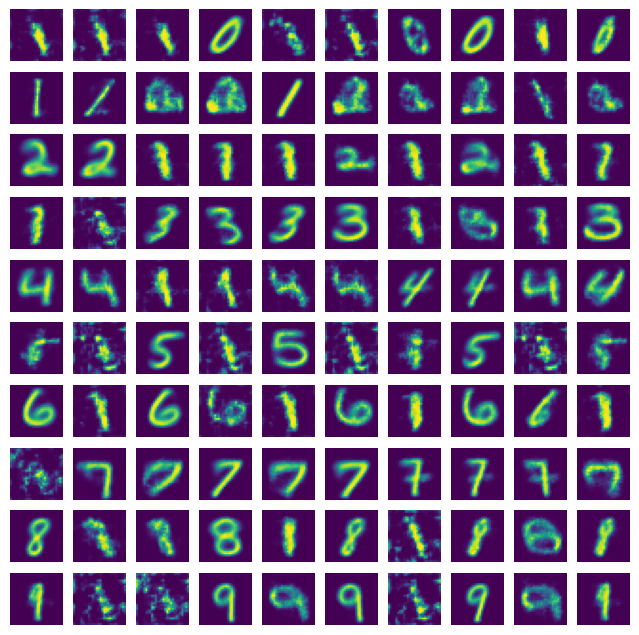

In [99]:
import matplotlib.pyplot as plt

x = output.reshape(100, 28, 28, 1)

plot_images = iter(x)
fig, ax = plt.subplots(10, 10, figsize=(8, 8))

for i in range(10):
    for j in range(10):
        ax[i][j].imshow(next(plot_images))
        ax[i][j].axis('off')

Further training will lead to better results.